## Quadrotor Environment

We use one of the [safe-control-gym](https://github.com/utiasDSL/safe-control-gym) environment.
> Please make sure that you have installed necessary packages to run the following cells.

### MPC and RL agent comparison

- Train PPO agent
- MPC Ablation on horizon and hindsight
- Compare RL agent and MPC variants
> Note that, we use [stable baselines 3](https://stable-baselines3.readthedocs.io/en/master/) repository as the source of RL agent implementation.

In [3]:
from itertools import product
from functools import partial
import os
import multiprocessing
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

from io_agent.plant.quadrotor import QuadrotorEnv
from io_agent.control.ppo import PPoController
from io_agent.evaluator import ControlLoop
from io_agent.plant.base import Plant
from io_agent.runner.basic import run_mpc
from io_agent.utils import parallelize, save_experiment


n_cpu = multiprocessing.cpu_count()
n_trials = 20
mpc_horizons = [15, 20, 25, 30, 35, 40]
general_seed = 42
seed_rng = np.random.default_rng(general_seed)

plant = QuadrotorEnv()
trial_seeds = seed_rng.integers(0, 2**30, n_trials)

ppo_path = f"./quadrotor_data/ppo-1m-{general_seed}"
if not os.path.exists(".".join([ppo_path, "zip"])):
    PPoController.train(lambda: QuadrotorEnv(use_exp_reward=True),
                        n_envs=10,
                        seed=general_seed,
                        path=ppo_path,
                        total_timesteps=int(1e6))
ppo_agent = PPoController(ppo_path)

ablation_keys = list(product(mpc_horizons, [True, False]))


def run_mpc_experiment(plant: Plant, horizon: int, use_hindsight: bool):
    return parallelize(
        n_proc=min(n_cpu, n_trials),
        fn=partial(run_mpc, plant=plant),
        kwargs_list=[
            dict(
                horizon=horizon,
                use_foresight=use_hindsight,
                bias_aware=False,
                env_reset_rng=np.random.default_rng(_seed)
            ) for _seed in trial_seeds
        ],
        loading_bar_kwargs=dict(desc=f"MPC with horizon:{horizon} and hindsight: {use_hindsight}")
    )


def evaluate_ppo(seed: int):
    return ControlLoop(plant=plant,
                       controller=ppo_agent,
                       rng=np.random.default_rng(seed)
                       ).simulate(False, False)


mpc_ablation_trajectories = parallelize(
    n_proc=n_cpu // min(n_cpu, n_trials),
    fn=partial(run_mpc_experiment, plant=plant),
    kwargs_list=[dict(horizon=horizon, use_hindsight=hindsight)
                 for horizon, hindsight in ablation_keys],
    loading_bar_kwargs=dict(desc=f"MPC ablation study")
)

ppo_trajectories = [
    evaluate_ppo(seed=_seed)
    for _seed in tqdm(trial_seeds, desc=f"PPO agent evaluation")
]

# Save the experiment since it takes some time to complete.
save_experiment(
    values={
        "mpc_ablation_trajectories": {
            key: trajectories for key, trajectories in zip(ablation_keys, mpc_ablation_trajectories)},
        "ppo_trajectories": ppo_trajectories
    },
    seed=general_seed,
    exp_dir="./quadrotor_data/ablation",
    name="mpc_vs_ppo")

ModuleNotFoundError: No module named 'safe_control_gym'

In [ ]:
from io_agent.utils import steady_state_cost, load_experiment
from io_agent.plotter import tube_figure

exp_trajectories = load_experiment("./quadrotor_data/ablation/mpc_vs_ppo-42")
mpc_trajectories = exp_trajectories["mpc_ablation_trajectories"]
ppo_trajectories = exp_trajectories["ppo_trajectories"]

tube_figure(
    cost_data={
        "MPC (w/ Hindsight)": {key[0]: steady_state_cost(traj, 0.4)
                               for key, traj in mpc_trajectories.items() if key[1] == True},
        "MPC (w/o Hindsight)": {key[0]: steady_state_cost(traj, 0.4)
                                for key, traj in mpc_trajectories.items() if key[1] == False},
        "PPO": {key[0]: (steady_state_cost(ppo_trajectories, 0.4))
                for key in mpc_trajectories.keys()}
    },
    title=f"Quadrotor 2D - Expert Performance Comparison",
    log_xaxis=False,
    log_yaxis=True,
    xaxis_name="MPC horizon",
    percentiles=(20, 80)
)

- IO-MPC lookback horizon ablation

In [ ]:
from typing import List
from functools import partial
import multiprocessing
import numpy as np

from io_agent.evaluator import Transition
from io_agent.plant.quadrotor import QuadrotorEnv
from io_agent.runner.basic import run_mpc, run_io_mpc
from io_agent.utils import parallelize, save_experiment


n_cpu = multiprocessing.cpu_count()
horizon = 25
n_trials = n_cpu // 4
n_dataset_trials = 20
general_seed = 42
lookbacks = [0, 2, 4, 8, 12, 16]
seed_rng = np.random.default_rng(general_seed)

plant = QuadrotorEnv()
permute_seed, *trial_seeds = seed_rng.integers(0, 2**30, n_trials + 1)
dataset_trial_seeds = seed_rng.integers(0, 2**30, n_dataset_trials)

dataset_trajectories = parallelize(
    n_proc=min(n_cpu, n_dataset_trials),
    fn=partial(run_mpc, plant=plant),
    kwargs_list=[
        dict(
            horizon=horizon,
            use_foresight=False,  # Without hindsight data
            bias_aware=False,
            env_reset_rng=np.random.default_rng(_seed)
        ) for _seed in dataset_trial_seeds
    ],
    loading_bar_kwargs=dict(desc="MPC dataset trials")
)


def lookback_horizon_experiment(n_past: int) -> List[List[Transition]]:
    return parallelize(
        n_proc=min(n_trials, n_cpu),
        fn=run_io_mpc(dataset_trajectories,
                      dataset_length=300,
                      n_past=n_past,
                      add_bias=False,
                      expert_horizon=horizon,
                      plant=plant,
                      dataset_permute_rng=np.random.default_rng(permute_seed)),
        kwargs_list=[
            dict(env_reset_rng=np.random.default_rng(_seed))
            for _seed in trial_seeds
        ],
        loading_bar_kwargs=dict(desc=f"IO-MPC, H:{n_past}")
    )


ablation_trajectories = parallelize(
    n_proc=n_cpu // min(n_trials, n_cpu),
    fn=lookback_horizon_experiment,
    kwargs_list=[dict(n_past=n_past) for n_past in lookbacks],
    loading_bar_kwargs=dict(desc="IO-MPC H-ablation")
)

# Save the experiment since it takes some time to complete.
save_experiment(
    values={"h_ablation": {
        key: trajectories for key,
        trajectories in zip(lookbacks, ablation_trajectories)}},
    seed=general_seed,
    exp_dir="./quadrotor_data/ablation",
    name="io_mpc_lookbacks")

In [ ]:
from io_agent.utils import steady_state_cost, load_experiment
from io_agent.plotter import tube_figure

exp_trajectories = load_experiment("./quadrotor_data/ablation/io_mpc_lookbacks-42")
io_mpc_trajectories = exp_trajectories["h_ablation"]
exp_trajectories = load_experiment("./quadrotor_data/ablation/mpc_vs_ppo-42")
mpc_trajectories = exp_trajectories["mpc_ablation_trajectories"]

tube_figure(
    cost_data={
        "IO-MPC (25)": {key: steady_state_cost(traj, 0.4)
                        for key, traj in io_mpc_trajectories.items()},
        "MPC (25, w/ Hindsight)": {key: steady_state_cost(mpc_trajectories[(25, True)], 0.4)
                               for key in io_mpc_trajectories.keys()},
        "MPC (25, w/o Hindsight)": {key: steady_state_cost(mpc_trajectories[(25, False)], 0.4)
                                for key in io_mpc_trajectories.keys()},
    },
    title=f"Quadrotor 2D - Controller Memory Ablation",
    log_xaxis=False,
    log_yaxis=False,
    xaxis_name="lookback horizon",
    percentiles=(40, 60)
)

- IO-RMPC $\rho$ Ablation

In [ ]:
from typing import List
from itertools import product
from functools import partial
import numpy as np
import multiprocessing

from io_agent.evaluator import Transition
from io_agent.plant.quadrotor import QuadrotorEnv
from io_agent.runner.basic import run_mpc, run_io_rmpc
from io_agent.utils import parallelize, save_experiment


n_cpu = multiprocessing.cpu_count()
horizon = 25
n_trials = 20
n_past = 2
add_bias = False
n_dataset_trials = 20
n_rhos = 12
general_seed = 42
seed_rng = np.random.default_rng(general_seed)

plant = QuadrotorEnv()
permute_seed, *trial_seeds = seed_rng.integers(0, 2**30, n_trials + 1)
dataset_trial_seeds = seed_rng.integers(0, 2**30, n_dataset_trials)

dataset_trajectories = parallelize(
    n_proc=min(n_cpu, n_dataset_trials),
    fn=partial(run_mpc, plant=plant),
    kwargs_list=[
        dict(
            horizon=horizon,
            use_foresight=False,  # Without hindsight data
            bias_aware=False,
            env_reset_rng=np.random.default_rng(_seed)
        ) for _seed in dataset_trial_seeds
    ],
    loading_bar_kwargs=dict(desc="MPC dataset trials")
)


def rho_experiment(rho: float) -> List[List[Transition]]:
    return parallelize(
        n_proc=min(n_cpu, n_trials),
        fn=run_io_rmpc(dataset_trajectories,
                      dataset_length=300,
                      n_past=n_past,
                      add_bias=add_bias,
                      expert_horizon=horizon,
                      expert_rho=rho,
                      plant=plant,
                      dataset_permute_rng=np.random.default_rng(permute_seed)),
        kwargs_list=[
            dict(env_reset_rng=np.random.default_rng(_seed))
            for _seed in trial_seeds
        ],
        loading_bar_kwargs=dict(desc=f"MPC rho:{rho} trials")
    )


rho_values = np.logspace(-2, -0.5, n_rhos)
ablation_trajectories = parallelize(
    n_proc=n_cpu // min(n_cpu, n_trials),
    fn=rho_experiment,
    kwargs_list=[
        dict(rho=rho)
        for rho in rho_values
    ],
    loading_bar_kwargs=dict(desc="IO-MPC rho ablation")
)

# Save the experiment since it takes some time to complete.
save_experiment(
    values={"rho_ablation": {key: trajectories for key,
                           trajectories in zip(rho_values, ablation_trajectories)}
                           },
    seed=general_seed,
    exp_dir="./quadrotor_data/ablation",
    name="io_rmpc_rho"
)

In [ ]:
from io_agent.utils import steady_state_cost, load_experiment
from io_agent.plotter import tube_figure

exp_trajectories = load_experiment("./quadrotor_data/ablation/io_rmpc_rho-42")
io_rmpc_trajectories = exp_trajectories["rho_ablation"]


tube_figure(
    cost_data={
        "IO-RMPC (25)": {key: steady_state_cost(traj, 0.4)
                        for key, traj in io_rmpc_trajectories.items()},
    },
    title=f"rho ablation",
    log_xaxis=True,
    log_yaxis=True,
    xaxis_name="rho",
    percentiles=(20, 80)
)

## CQL comparisons

- Run CQL on MPC Quadrotor dataset with 4 seeds for 8 different dataset lengths
- Evaluate CQL policies with 20 seeds for each epoch, data size, and training seed
- Compare it with IO agent

Run the following command to train a CQL controller. Note that, ```n_trajectories``` determines number of trajectories that is going to be used in the training. Each trajectory contains 300 steps.


```bash
python cql_quadrotor.py --n_trajectories 12 --device cuda:0 --seed 42
```
> **Note that:** The experiments require GPUs. In the paper, we evaluated each dataset size (different ```n_trajectories```) with 4 different seeds (42, 43, 44, 45).

The trained agents will be used for evaluations.

### Evaluation

Run the cell below to evaluate the trained CQL agents. The evaluation process expects to have checkpoints under the checkpoints folder of each training.

- Generate Trajectories

In [ ]:
from run_cql import generate_mpc_quadrotor_dataset


generate_mpc_quadrotor_dataset(
    horizon=25,
    n_dataset_trials=100,
    seed=42,
)

- Run cql trainings with 4 different seeds and with multiple trajectories

In [ ]:
from itertools import product
import torch

from run_cql import train_quadrotor_cql


device = "cuda" if torch.cuda.is_available() else "cpu"
for seed, n_trajectories in product([42, 43, 44, 45], [100, 80, 50, 25, 20, 15, 12, 10]):
    train_quadrotor_cql(
        n_trajectories=n_trajectories,
        device=device,
        seed=seed,
    )

In [ ]:
# Evaluation
from io_agent.utils import save_experiment
from run_cql import evaluate_all_cql_quadrotor_policies


cql_evaluations = evaluate_all_cql_quadrotor_policies(
    experiment_path="./offlineRL_dataa/Quadrotor2d/cql",
    cql_seeds=[42, 43, 44, 45],
    data_sizes=[100, 80, 50, 25, 20, 15, 12, 10],
    epochs_numbers=list(range(1, 51)),
    initial_seed=42,
    n_trials=20,
    n_proc=20,
)
save_experiment(
    values={"cql": cql_evaluations},
    seed=0,
    exp_dir="./quadrotor_data/ablation",
    name="cql_epochs_and_dataset_length"
)

## Process and Accumulate the Evaluations Scores
> Note: You need to run the above cells in order to generate the data
- Convert rewards into costs
- Get evaluations of IO and MPC agents from previous experiments
- Get evaluation scores of the CQL and PPO agents.

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

from io_agent.utils import load_experiment
from io_agent.plotter import histogram_figure_plt, tube_figure_plt


exp_trajectories = load_experiment("./quadrotor_data/ablation/io_mpc_lookbacks-42")
io_mpc_trajectories = exp_trajectories["h_ablation"]

exp_trajectories = load_experiment("./quadrotor_data/ablation/mpc_vs_ppo-42")
mpc_trajectories = exp_trajectories["mpc_ablation_trajectories"]

io_costs = [np.sum([1 - np.exp(-tran.cost) for tran in trajectory])
            for trajectory in io_mpc_trajectories[0]]
mpc_costs = [np.sum([1 - np.exp(-tran.cost) for tran in trajectory])
             for trajectory in mpc_trajectories[(25, False)]]
io_h_costs = {key: [[np.sum([1 - np.exp(-tran.cost) for tran in trajectory])]
                    for trajectory in trajectories]
              for key, trajectories in io_mpc_trajectories.items()}

# - - - - - - - - - - - - - - - - - - - - - - - -
# - - - - - - - - - - - CQL - - - - - - - - - - -
# - - - - - - - - - - - - - - - - - - - - - - - -

exp_trajectories = load_experiment("./quadrotor_data/ablation/cql_epochs_and_dataset_length-0")
cql_trajectories = exp_trajectories["cql"]

cql_datasize_eval = defaultdict(lambda: defaultdict(list))
for data_size, seed_evals in cql_trajectories.items():
    for seed_eval in seed_evals.values():
        for index, scores in seed_eval.items():
            cql_datasize_eval[data_size][index].extend([300 - s for s in scores])

cql_datasize_eval_median = {data_size: {key: np.median(evals) for key, evals in epoch_eval.items()}
                            for data_size, epoch_eval in cql_datasize_eval.items()}
best_indices = {data_size: min(median_eval.items(), key=lambda key: key[1])[0]
                for data_size, median_eval in cql_datasize_eval_median.items()}

exp_trajectories = load_experiment("./quadrotor_data/ablation/io_rmpc_rho-42")
io_rmpc_trajectories = exp_trajectories["rho_ablation"]

io_rho_costs = {rho: [np.sum([1 - np.exp(-tran.cost) for tran in trajectory]) for trajectory in trajectories]
                for rho, trajectories in io_rmpc_trajectories.items()}
best_io_rmpc_rho, best_io_rmpc_cost = min(io_rho_costs.items(), key=lambda key: np.median(key[1]))

# - - - - - - - - - - - - - - - - - - - - - - - -
# - - - - - - - - - - - PPO - - - - - - - - - - -
# - - - - - - - - - - - - - - - - - - - - - - - -

exp_trajectories = load_experiment("./quadrotor_data/ablation/mpc_vs_ppo-42")
ppo_trajectories = exp_trajectories["ppo_trajectories"]

ppo_costs = [np.sum([1 - np.exp(-tran.cost) for tran in trajectory])
             for trajectory in ppo_trajectories]


# - - - - - - - - - - - - - - - - - - - - - - - -
# - - - - - - - - - - - MPC vs PPO - - - - - - -
# - - - - - - - - - - - - - - - - - - - - - - - -

mpc_horizon_keys = [horizon for horizon, awareness in mpc_trajectories.keys()]
mpc_obl_costs = {key: [np.sum([1 - np.exp(-tran.cost) for tran in trajectory])
                       for trajectory in mpc_trajectories[(key, False)]]
                 for key in mpc_horizon_keys}
mpc_fdst_costs = {key: [np.sum([1 - np.exp(-tran.cost) for tran in trajectory])
                        for trajectory in mpc_trajectories[(key, True)]]
                  for key in mpc_horizon_keys}

### Plot the Figures in the paper

- Lookback Ablation of IO-MPC controller

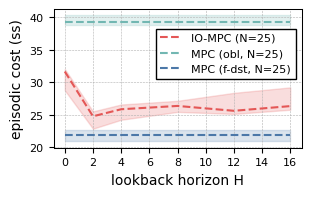

In [35]:
io_h_ss_costs = {key: [[30/18 * np.sum([1 - np.exp(-tran.cost) for tran in trajectory[120:]])]
                       for trajectory in trajectories]
                 for key, trajectories in io_mpc_trajectories.items()}
mpc_obl_ss_costs = [30/18 * np.sum([1 - np.exp(-tran.cost) for tran in trajectory[120:]])
                    for trajectory in mpc_trajectories[(25, False)]]
mpc_fdst_ss_costs = [30/18 * np.sum([1 - np.exp(-tran.cost) for tran in trajectory[120:]])
                     for trajectory in mpc_trajectories[(25, True)]]

fig, axes = tube_figure_plt(
    cost_data={
        "IO-MPC (N=25)": io_h_ss_costs,
        "MPC (obl, N=25)": {key: mpc_obl_ss_costs
                            for key in io_h_costs.keys()},
        "MPC (f-dst, N=25)": {key: mpc_fdst_ss_costs
                              for key in io_h_costs.keys()},
    },
    color_list=["#E45756", "#72B7B2", "#4C78A8"],
    log_xaxis=False,
    # log_yaxis=True,
    x_label="lookback horizon H",
    y_label="episodic cost (ss)",
    percentiles=(45, 55),
    figsize=(3.20, 1.80),
    fontsize=10,
)
axes.yaxis.set_major_locator(tck.MaxNLocator(5))
plt.legend(bbox_to_anchor=(0.39, 0.9), loc="upper left",
           frameon=True, edgecolor="inherit",
           framealpha=1.0, fancybox=False)
fig.savefig(f"figure_data/io_lookback_ablation.pdf",
            format="pdf", bbox_inches="tight")

- Horizon Ablation of MPC controllers

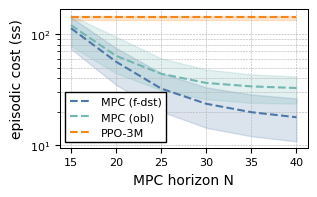

In [50]:
fig, axes = tube_figure_plt(
    cost_data={
        "MPC (f-dst)": mpc_fdst_costs,
        "MPC (obl)": mpc_obl_costs,
        "PPO-3M": {key: ppo_costs for key in mpc_obl_costs.keys()}
    },
    color_list=["#4C78A8", "#72B7B2", "#F58518"],
    log_xaxis=False,
    log_yaxis=True,
    x_label="MPC horizon N",
    y_label="episodic cost (ss)",
    percentiles=(20, 80),
    figsize=(3.20, 1.80),
    fontsize=10,
)
axes.yaxis.set_minor_locator(tck.LogLocator(base=10, subs="auto"))
axes.yaxis.set_major_locator(tck.LogLocator(base=10, subs=(1,), numticks=9))
fig.savefig(f"figure_data/mpc_horizon_ablation.pdf",
            format="pdf", bbox_inches="tight")

- $\rho$ Ablation of IO-RMPC controllers

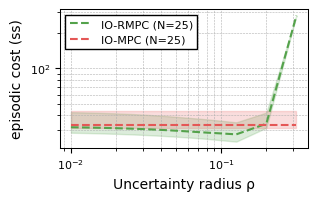

In [37]:
fig, axes = tube_figure_plt(
    cost_data={
        "IO-RMPC (N=25)": io_rho_costs,
        "IO-MPC (N=25)": {rho: io_costs for rho in io_rho_costs.keys()},
    },
    color_list=["#54A24B","#E45756"],
    log_xaxis=True,
    log_yaxis=True,
    x_label="Uncertainty radius ρ",
    y_label="episodic cost (ss)",
    percentiles=(40, 60),
    figsize=(3.20, 1.80),
    fontsize=10,
)
axes.yaxis.set_minor_locator(tck.LogLocator(base=10, subs="auto"))
axes.yaxis.set_major_formatter(tck.LogFormatterMathtext())

fig.savefig(f"figure_data/rho_ablation.pdf", format="pdf", bbox_inches="tight")


- Dataset size ablation of CQL controllers

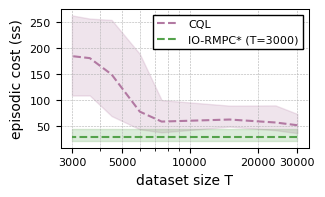

In [38]:
fig, axes = tube_figure_plt(
    cost_data={
        f"CQL": {data_size * 300: epoch_evals[best_indices[data_size]]
                 for data_size, epoch_evals in cql_datasize_eval.items()},
        "IO-RMPC* (T=3000)": {data_size * 300: io_rho_costs[best_io_rmpc_rho]
                    for data_size in cql_datasize_eval.keys()}
    },
    color_list=["#B279A2","#54A24B"],
    log_xaxis=True,
    log_yaxis=False,
    x_label="dataset size T",
    y_label="episodic cost (ss)",
    percentiles=(20, 80),
    figsize=(3.20, 1.80),
    fontsize=10,
)
axes.xaxis.set_major_formatter(tck.ScalarFormatter())
axes.set_xticks([3000, 5000, 10000, 20000, 30000])
fig.savefig(f"figure_data/dataset_ablation.pdf", format="pdf", bbox_inches="tight")


- Comparison between IO and MPC controllers

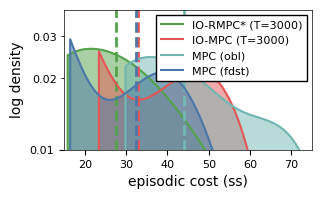

In [51]:
fig, axes = histogram_figure_plt(
    cost_data={
        "IO-RMPC* (T=3000)": io_rho_costs[best_io_rmpc_rho],
        "IO-MPC (T=3000)": io_costs,
        "MPC (obl)": mpc_costs,
        "MPC (fdst)": mpc_fdst_costs[25],
    },
    color_list=["#54A24B","#E45756", "#72B7B2", "#4C78A8"],
    log_yaxis=True,
    y_label="log density",
    x_label="episodic cost (ss)",
    low_y=1e-2,
    figsize=(3.20, 1.82),
    fontsize=10,
)
axes.set_xlim(15, 75)
axes.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
axes.yaxis.set_minor_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
fig.savefig(f"figure_data/hist_2.pdf", format="pdf", bbox_inches="tight")

- Comparison between offline IO, CQL, and online PPO controllers

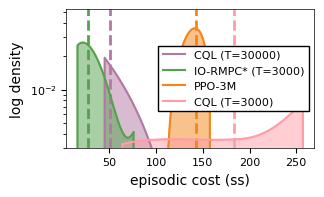

In [40]:
fig, axes = histogram_figure_plt(
    cost_data={
        f"CQL (T=30000)": cql_datasize_eval[100][best_indices[100]],
        "IO-RMPC* (T=3000)": io_rho_costs[best_io_rmpc_rho],
        f"PPO-3M": ppo_costs,
        f"CQL (T=3000) ": cql_datasize_eval[10][best_indices[10]],
    },
    color_list=["#B279A2","#54A24B","#F58518","#FF9DA6"],
    log_yaxis=True,
    y_label="log density",
    x_label="episodic cost (ss)",
    low_y=3e-3,
    figsize=(3.20, 1.80),
    fontsize=10,
)
# plt.legend(
#     frameon=True,
#     edgecolor="inherit",
#     framealpha=1.0,
#     fancybox=False,
#     loc="upper right",
#     bbox_to_anchor=(1.0, 0.85),
# )
fig.savefig(f"figure_data/hist_1.pdf", format="pdf", bbox_inches="tight")